In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_paths = {'in':'../data/enriched/Ride_to_alum_creek.csv',
              'out':'../data/enriched/Ride_to_alum_creek.csv'
             }

df = pd.read_csv(file_paths['in'])

In [3]:
df.dtypes

track             int64
segment           int64
time             object
time_utc        float64
time_diff       float64
elapsed_time    float64
elevation       float64
latitude        float64
longitude       float64
dtype: object

In [4]:
# convert the time column to a datetime type
df['time'] = pd.to_datetime(df['time'])

# 1. Calculating Distance Travelled

In [5]:
from haversine import haversine

In [6]:
def compute_distance(df, latitude='latitude', longitude='longitude'):
    df = df.copy()
    # Copy the previous values of Lat/Long to the current row for vectorized computation
    df['lat_old'] = df[latitude].shift()
    df['long_old'] = df[longitude].shift()
    
    # Grab the relevant columns for distance calculation
    df = df[['lat_old', 'long_old', latitude, longitude]]
    
    # Define an anonymous function to execute over each row to calculate the distance between rows
    haversine_distance = lambda x: haversine((x[0], x[1]), (x[2], x[3]), unit='mi')
    
    # Create the distance column, making sure to apply the function row-by-row
    df['distance'] = df.apply(haversine_distance, axis=1)
    return df['distance']
    

In [8]:
df['distance'] = compute_distance(df)

In [10]:
# compute the cumulative distance elapsed
df['elapsed_distance'] = df['distance'].cumsum()

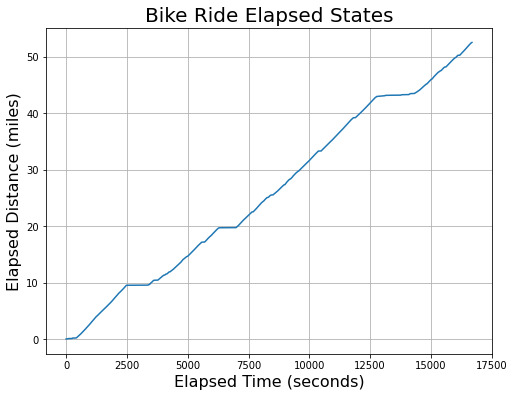

In [13]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(8,6))

_ = plt.plot(df['elapsed_time'], df['elapsed_distance'])
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Elapsed Distance (miles)', fontsize=16)
_ = plt.title('Bike Ride Elapsed States', fontsize=20)
_ = plt.grid()